<p align="center">
  <img width="300" height="300" src="https://www.linkpicture.com/q/VISTRKR_Logo1.png">
</p>

## Brief

The provided Python code performs the following tasks:

1. Imports necessary modules and functions for calibration, estimation, and simulation.
2. Defines camera configurations and calibration data.
3. Calibrates the cameras using the calibration data.
4. Defines a lambda function to generate points.
5. Generates points within specified limits using the defined lambda function.
6. Simulates measurements using the calibrated cameras and generated points, adding noise to the measurements.
7. Estimates the position of the points using the calibrated cameras and simulated measurements.

Overall, the code demonstrates a process of calibrating cameras, generating and simulating data, and estimating the position of points based on the simulated measurements.

## Modules

In [1]:
import numpy as np
import math

# Import functions from different modules
from calibration import calib_functions
from estimation import estim_functions
from simulation import sim_functions

from main import calibrate_cameras, estimate_position, simulate_data

from data.experiment_data import *

## Data Analysis

In [2]:
# Create a dictionary to store calibration data
calibration_data = {}

# Store the locations of the points
calibration_data['points'] = list(p_i_locations.values())

# Store the pixel data for cameras O, Dx, and By
calibration_data['pixels'] = {'O': list(data_O.values()),
                              'Dx': list(data_Dx.values()),
                              'By': list(data_By.values())}

# Define camera configurations
cam_O = {'name': 'O', 'position': (0, 0), 'azimuth': 45}
cam_Dx = {'name': 'Dx', 'position': (20, 0), 'azimuth': 135}
cam_By = {'name': 'By', 'position': (0, 10), 'azimuth': 0}

# Calibrate the cameras using the calibration data
cameras_data = calibrate_cameras([cam_O, cam_Dx, cam_By], calibration_data)

# Define a lambda function foo(x)
foo = lambda x: 1.5 * np.cos(x / 1.2) + 1.2 * x

# Generate points using the sim_functions module
p = sim_functions.generate_points(foo, x_limits=[2, 18], y_limits=[2, 18], density=30)

# Simulate measurements using the cameras_data and generated points
measurements = simulate_data(cameras_data, p, noise_std=15)

# Estimate the position of the points using cameras_data and measurements
points = estimate_position(cameras_data, measurements)

dt = 1
poly_deg = 4
alpha = .5
result = np.zeros(points.shape)
result[:poly_deg+1] = points[:poly_deg+1]
for i in range(poly_deg+1, points.shape[0]):
    points_subset = points[:i, :]
    x = points_subset[:, 0]
    y = points_subset[:, 1]
    
    coefficients = np.polyfit(x, y, poly_deg)
    polynomial = np.poly1d(coefficients)
    
    x_pol = np.linspace(x.min(), x.max(), len(x))
    y_pol = polynomial(x_pol)
    
    dx = x_pol[-1] - x_pol[-2]
    dy = y_pol[-1] - y_pol[-2]
    dr = np.linalg.norm(np.array([dx, dy]))
#     tangent_slope = dy / dx
    angle = np.arctan2(dy, dx)
    
    next_point = alpha * np.array([np.cos(angle) * dr, np.sin(angle) * dr]) + (1 - alpha) * points[i, :]
    result[i, :] = next_point

## Visualization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_filled_sector(center, azimuth, radius, AOV, ax, sector_color='blue'):
    start_angle = azimuth - int(AOV/2)
    end_angle = azimuth + int(AOV/2)

    # Create a Wedge patch to represent the sector
    sector = patches.Wedge(center, radius, start_angle, end_angle, fc=sector_color)

    # Add the sector patch to the plot
    ax.add_patch(sector)
    ax.plot(center[0], center[1], 'r.', markersize=10)

<IPython.core.display.Javascript object>


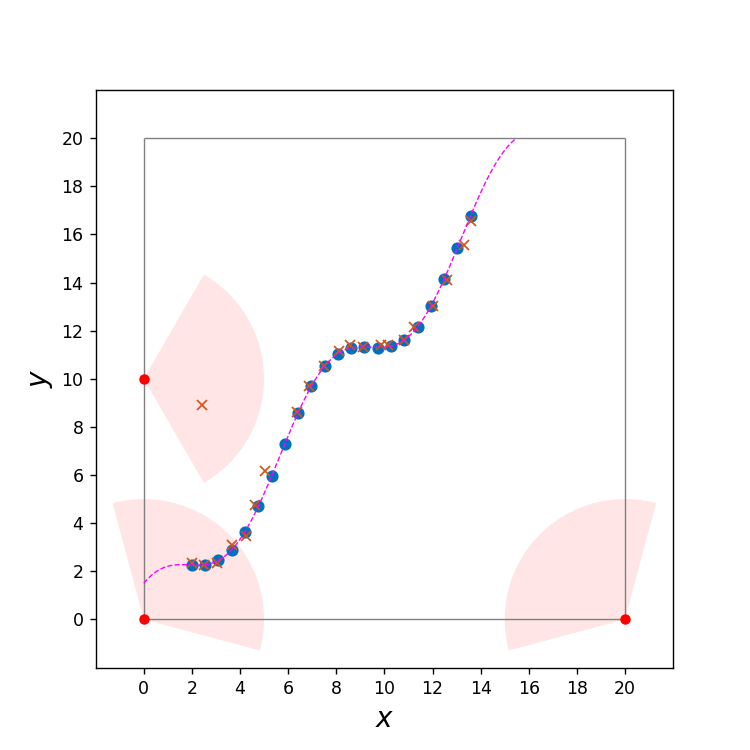

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib notebook
X = np.linspace(0, 20, 500)
Y = foo(X)
mask = (0<=X) & (X<=20) & (0<=Y) & (Y<=20)
p = np.array(p)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

ax.plot(p[:, 0], p[:, 1], 'o', c='#0072BD')
ax.plot(points[:, 0], points[:, 1], 'x', c='#D95319')
# ax.plot(result[:, 0], result[:, 1], '*', c='#7E2F8E')
ax.plot(X[mask], Y[mask], lw=.8, ls='--', c='#FF00FF')

for camera in cameras_data:
    plot_filled_sector(camera['position'], camera['azimuth'], 5, 120, ax, sector_color=[1, 0, 0, .1])
    
ax.hlines([0, 20], 0, 20, colors='grey', lw=.8)
ax.vlines([0, 20], 0, 20, colors='grey', lw=.8)


ax.set_xticks(np.arange(0, 21, 2)) ; ax.set_yticks(np.arange(0, 21, 2))
ax.set_xlim([-2, 22]) ; ax.set_ylim([-2, 22])
ax.set_xlabel('$x$', size=16) ; ax.set_ylabel('$y$', size=16)
# ax.grid()
plt.show()